# Assignment B

We consider the following information spreading process, which is actually a simplified Susceptible-Infected
model but on a temporal network. Initially, at time t = 0, a single node s is infected meaning that this
node possesses the information whereas all the other nodes are Susceptible, thus have not yet perceived the
information. Node s is also called the seed of the information. Whenever an infected node i is in contact with
a susceptible node j at any time step t, the susceptible node becomes infected during the same time step and
could possibly infect other nodes only since the next time step via its contacts with susceptible nodes. Once a
node becomes infected, it stays infected forever. For example, assume that the seed node has its first contact,
e.g. with a node m at time t = 5. Although node s gets infected since t = 0, it infects a second node, i.e. node
m only at t = 5 when it contacts m. Infection happens only when an infected node and a susceptible node are
in contact. The number of infected nodes is non-decreasing over time.

Simulate the information spreading process on the given temporal network G data for N iterations. Each
iteration starts with a different seed node infected at t = 0 and ends at t = T = 57791 the last time step that
the network is measured. Record the number of infected nodes I(t) over time t for each iteration.

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os.path
import math

In [2]:
df = pd.read_excel('manufacturing_emails_temporal_network.xlsx')
number_of_nodes = 167
df

,node1,node2,timestamp
0,1,2,1
1,1,3,1
2,1,4,1
3,1,5,1
4,1,6,1
...,...,...,...
82871,3,39,57787
82872,3,39,57788
82873,18,19,57789
82874,3,85,57790


In [57]:
first_message = np.zeros(number_of_nodes, dtype=int)
count_of_messages_sent = np.zeros(number_of_nodes, dtype=int)
for index, transaction in df.iterrows():
    count_of_messages_sent[transaction['node1'] - 1] += 1
    if first_message[transaction['node1'] - 1] == 0:
        first_message[transaction['node1'] - 1] = transaction['timestamp']

node_firstmsg_pair = np.stack(
    (np.arange(1, 168),
     first_message), axis=-1)
sorted_node_first_pair = node_firstmsg_pair[node_firstmsg_pair[:, 1].argsort()][:, 0]

node_count_pair = np.stack(
    (np.arange(1, 168),
     first_message), axis=-1)
sorted_node_count_pair = node_count_pair[node_count_pair[:, 1].argsort()][:, 0]

print(count_of_messages_sent)
print(first_message)
print()
print(sorted_node_first_pair)
print(sorted_node_count_pair)

[3376 2160 8955 2482 1807  797  951 1001 2314  442  172 1167 4334 1415
 3826  137  937 1822  790  508 1063  560  713  935  395  854 1450  123
 1058  376  215  550  606   95  377  451  505  600  372 1476   92 1048
  599  600  684  185 1674 1236  238 3602   25  180 1420  743   50 1226
  856  625 2244   41  636   90  272  247 1183  930  578  916 1560  414
  607  371  116  147  357  512   93    1  186  278   88  231   96  586
  201  553   31  316   59   94    1  101  212  272  262   33    4   46
   30    7   30    2  213   94    6  121    3    9    5    1    1   16
   25    0   24    0    3    0    0    0    4   58    0    0    0    0
    0    0    0    0    0    0    0    0    0    1    0    0    0    0
    0    0    0    0    0    8    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0]
[    1    63     4    26    85   127    84    26   262    87    14   120
    26   171    92  1720    49     2    57     5    18    45    61     8
   164

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 18,
 18,
 3,
 20,
 20,
 20,
 24,
 26,
 28,
 1,
 29,
 28,
 11,
 11,
 11,
 11,
 11,
 11,
 1,
 21,
 3,
 36,
 36,
 11,
 24,
 21,
 36,
 21,
 3,
 13,
 8,
 13,
 13,
 4,
 42,
 42,
 42,
 42,
 42,
 26,
 21,
 3,
 1,
 1,
 47,
 8,
 47,
 8,
 42,
 21,
 21,
 26,
 22,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 1,
 17,
 17,
 3,
 1,
 55,
 50,
 3,
 3,
 27,
 19,
 27,
 19,
 19,
 23,
 19,
 19,
 2,
 24,
 27,
 21,
 24,
 42,
 3,
 23,
 2,
 3,
 3,
 33,
 23,
 42,
 62,
 62,
 3,
 13,
 4,
 50,
 23,
 21,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 21,
 24,
 7,
 5,
 5,
 5,
 5,
 5,
 11,
 10,
 24,
 4,
 3,
 3,
 27,
 15,
 7,
 1,
 50,
 13,
 13,
 50,
 50,
 15,
 3,
 20,
 8,
 33,
 35,
 5,
 3,
 3,
 15,
 20,
 8,
 33,
 35,
 15,
 15,
 3,
 15,
 20,
 8,
 33,
 35,
 15,
 8,
 8,
 8,
 3,
 15,
 20,
 8,
 33,
 35,
 3,
 3,
 35,
 35,
 3,
 20,
 8,
 33,
 35,
 15,
 15,
 8,
 35,
 3,
 35,
 3,
 4,
 15,
 12,
 30,
 1,
 15,
 19,
 3,
 15,
 6,
 1,
 6,
 1,
 5,
 3,
 27,
 23,
 27,
 43,
 43,
 48,
 43,
 43,
 7

## Q9

Taking all the N iterations into count, plot the average number of infected nodes $E[I(t)]$ together with
its error bar (standard deviation $\sqrt{Var[I(t)]}$) as a function of the time step t

In [31]:
try:
    infected_per_timestep = pickle.load(open("infected_per_timestamp.pickle", "rb"))
    time_to_infection = np.loadtxt(open('time-to-infection.csv', "rb"), delimiter=",")

except Exception as e:
    print(e)
    print("Rebuilding data")

    infected_per_timestep = np.zeros([number_of_nodes, df['timestamp'][len(df) - 1]])
    time_to_infection = np.full([number_of_nodes + 1, number_of_nodes + 1], -1)

    for n in range(1, number_of_nodes + 1):
        infected = np.zeros(number_of_nodes + 1,dtype=bool)
        infected[n] = True
        infected_count = 1

        time_to_infection[n, n] = 0

        for index, transaction in df.iterrows():
            node1 = transaction['node1']
            node2 = transaction['node2']
            if infected[node1] and not infected[node2]:
                infected[node2] = True
                infected_count += 1
                if infected_count / number_of_nodes <= 0.8:
                    time_to_infection[n, node2] = transaction['timestamp']

            infected_per_timestep[n - 1, transaction['timestamp'] - 1] = infected_count


        print("Infection of starting node " + str(n) + " finished")
    pickle.dump(infected_per_timestep, open("infected_per_timestamp.pickle", "wb"))    

    print("Finished creating data")
print("infected_per_timestep initialized")
print(infected_per_timestep)
print(time_to_infection)

infected_per_timestep initialized
[[ 17.  17.  17. ... 167. 167. 167.]
 [  1.   1.   1. ... 162. 162. 162.]
 [  1.   1.   1. ... 165. 165. 165.]
 ...
 [  1.   1.   1. ...   1.   1.   1.]
 [  1.   1.   1. ...   1.   1.   1.]
 [  1.   1.   1. ...   1.   1.   1.]]
[[-1. -1. -1. ... -1. -1. -1.]
 [-1.  0.  1. ... -1. -1. -1.]
 [-1. -1.  0. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ...  0. -1. -1.]
 [-1. -1. -1. ... -1.  0. -1.]
 [-1. -1. -1. ... -1. -1.  0.]]


In [32]:
np.savetxt("time-to-infection.csv", time_to_infection, delimiter=",")
np.savetxt("infected-per-timestep-Gdata", infected_per_timestep, delimiter=",")
print("save to csv")

save to csv


In [33]:
try:
    os.path.isfile('Infected_per_timestep.xlsx')
    print("Excelfile already there")
except Exception as e:
    print(e)
    print("Writing data to excel")
    df_infected_per_timestep = pd.DataFrame(infected_per_timestep.T)
    writer = pd.ExcelWriter('Infected_per_timestep.xlsx')
    df_infected_per_timestep.to_excel(writer, 'Sheet1', index=False)
    writer.save()
    print("Written infected per timestep to excel")



Excelfile already there


In [34]:
avg = [np.average(col) for col in infected_per_timestep.T]
std = [np.std(col) for col in infected_per_timestep.T]
print("Array length avg" + str(len(avg)) + ": " +str(avg[0:5]))
print("Array length std" + str(len(std)) + ": " +str(std[0:5]))


Array length avg57791: [1.095808383233533, 1.1017964071856288, 1.1017964071856288, 1.1137724550898203, 1.1317365269461077]
Array length std57791: [1.2344046684287548, 1.2363493224702797, 1.2363493224702797, 1.3151314757554533, 1.3995332763674446]


Text(0, 0.5, 'Infected nodes')

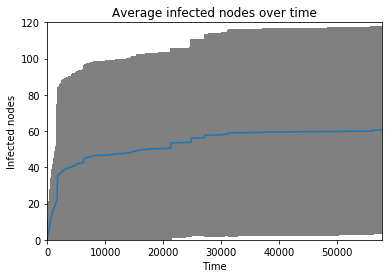

In [35]:
plt.errorbar(np.arange(1,len(avg) + 1), avg, yerr=std, ecolor='grey')
plt.title("Average infected nodes over time")
plt.gca().set_xlim([0,57791])
plt.gca().set_ylim([0, 120])
plt.xlabel('Time')
plt.ylabel('Infected nodes')

## Q10

How influential a node is as a seed node could be partially reflected by, e.g. the time it takes to
reach/infect 80% of the total nodes when this node is selected as the seed node. The shorter the time is, the more influential the seed node is. Using this standard to rank the influence of all the nodes and record the
ranking in a vector R = [R (1) , R (2) , ..., R (N ) ] where R (i) is the node index of the i − th most influential seed
node and R (1) is the most influential node that infects 80% nodes in the shortest time. Note that you don’t
need to provide this vector in your report

In [36]:
threshold = math.ceil(0.8 * number_of_nodes)

threshold_reached = [np.min(np.where(row > threshold)[0]) 
         if np.where(row > threshold )[0].shape[0] > 0 
         else len(infected_per_timestep.T)                     
         for row in infected_per_timestep]

In [37]:
node_timestamp_pair = np.stack(
    (np.arange(1,168), 
    np.array(threshold_reached)), axis=-1  )
sorted_nodes = node_timestamp_pair[node_timestamp_pair[:,1].argsort()][:,0]

## Q11

We are going to explore which nodal level network feature could well suggest the nodal influence discussed
in 10). Compute the degree and clustering coefficient of each node in the aggregated network G and rank the
importance of the nodes according to these two centrality metrics respectively. You obtain the ordered vector
D = [D (1) , D (2) , ..., D (N ) ] and C = [C (1) , C (2) , ..., C (N ) ], where D (i) is the node having the i − th highest degree
and C (i) is the node with the i − th highest clustering coefficient. How precise a centrality metric e.g. the
|R f ∩D f |
degree could predict seed nodes’ influence could be quantified by the top f recognition rate r RD (f ) = |R
f |
where R f and D f are the sets of nodes ranking in the top f fraction according to their influence and degree
respectively and |R f | = f N is the number of nodes in R f . Plot r RD (f ) and r RC (f ) as a function of f where
f = 0.05, 0.1, 0.15, ..., 0.5. Which metric, the degree or the clustering coefficient could better predict the influence
of the nodes? Why?

In [38]:
G = nx.from_pandas_edgelist(df, source='node1', target='node2')

degree_vector = np.array(G.degree())
sorted_degree_vector = degree_vector[degree_vector[:,1].argsort()][::-1][:,0]

cl_vector = np.array([[a, b] for (a,b) in nx.clustering(G).items()])
sorted_cl_vector = cl_vector[cl_vector[:,1].argsort()][::-1][:,0]

In [39]:
f_range = np.arange(0.05, 0.55, 0.05)
recognition_rate = np.zeros((2,len(f_range)))
for i in range(0,len(f_range)):
    f = f_range[i]
    selection_range = math.floor(f * number_of_nodes)
    
    d_intersection = [n for n 
         in sorted_nodes[0:selection_range] 
         if n in sorted_degree_vector[0:selection_range]  ]
    recognition_rate[0,i] = len(d_intersection)/selection_range

    c_intersection = [n for n 
         in sorted_nodes[0:selection_range] 
         if n in sorted_cl_vector[0:selection_range]  ]
    recognition_rate[1,i] = len(c_intersection)/selection_range
print(recognition_rate)
print("")
print(sorted_nodes[0:9])
print(sorted_degree_vector[0:9])
print(sorted_cl_vector[0:9])


[[0.125      0.1875     0.24       0.39393939 0.34146341 0.36
  0.37931034 0.37878788 0.34666667 0.3373494 ]
 [0.         0.         0.         0.18181818 0.3902439  0.48
  0.53448276 0.53030303 0.50666667 0.53012048]]

[ 1  3  4  6  7  8  9 13  2]
[ 38  45  37   1  47  35 113 115  50]
[135. 134. 132. 114. 131. 129. 127. 160. 126.]


In [40]:
f_range = np.arange(0.05, 0.55, 0.05)
[[n for n in sorted_degree_vector[0:math.floor(f * number_of_nodes)]
                     if n in sorted_nodes[0:math.floor(f * number_of_nodes)]] 
                     for f in f_range]
# recognition_rate_vector = np.zeros(len(f_range))
# for i in range(0, len(f_range)):
#     f = f_range[i]
#     selection_range = math.floor(f * number_of_nodes)

#     d_intersection = [n for n
#                       in sorted_degree_vector[0:selection_range]
#                       if n in sorted_nodes[0:selection_range]]
#     recognition_rate_vector[i] = len(d_intersection) / selection_range
# print(recognition_rate_vector)

[[1],
 [1, 18, 7],
 [1, 18, 23, 7, 2, 3],
 [1, 18, 23, 7, 29, 2, 3, 27, 4, 14, 15, 13, 9],
 [1, 18, 23, 7, 29, 2, 3, 27, 4, 14, 15, 13, 9, 10],
 [1, 18, 23, 7, 29, 2, 3, 27, 4, 14, 15, 13, 9, 10, 8, 21, 22, 5],
 [1,
  115,
  18,
  23,
  7,
  29,
  2,
  3,
  27,
  4,
  14,
  15,
  13,
  9,
  10,
  8,
  21,
  22,
  5,
  26,
  104,
  117],
 [1,
  113,
  115,
  18,
  23,
  7,
  29,
  2,
  3,
  27,
  4,
  14,
  112,
  15,
  13,
  9,
  10,
  8,
  21,
  22,
  5,
  26,
  104,
  117,
  20],
 [1,
  113,
  115,
  18,
  23,
  7,
  29,
  2,
  3,
  27,
  4,
  14,
  112,
  15,
  13,
  9,
  10,
  8,
  21,
  22,
  5,
  26,
  104,
  117,
  20,
  6],
 [1,
  113,
  115,
  18,
  23,
  7,
  29,
  2,
  3,
  27,
  4,
  14,
  112,
  15,
  13,
  9,
  10,
  8,
  21,
  22,
  5,
  26,
  104,
  117,
  20,
  6,
  24,
  19]]

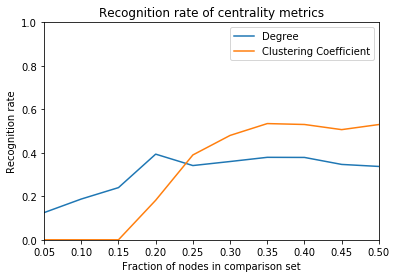

In [41]:
plt.plot(f_range, recognition_rate[0])
plt.plot(f_range, recognition_rate[1])
plt.title("Recognition rate of centrality metrics")
plt.gca().set_xlim([0.05,0.5])
plt.gca().set_ylim([0, 1])
plt.xlabel('Fraction of nodes in comparison set')
plt.ylabel('Recognition rate')
plt.legend(['Degree', 'Clustering Coefficient'])

## Q13

How influential a node is as a seed node can be also reflected by the average time for the information
started by this seed at t = 0 to reach any other node that belongs to the 80% · N nodes that are reached
first in time. Use this standard to rank the influence of all the nodes and record the ranking in a vector R 0 = [R (1), R (2), ..., R (N) ]. Which metric, R, the degree or the clustering coefficient, could better predict the influence ranking R ? Hint: use the method proposed in 11).

In [42]:
average_time_to_infection = [np.average(row[np.where(row > 0)]) 
         if np.where(row > 0)[0].shape[0] > 0
         else -1
         for row in time_to_infection]
average_time_to_infection.pop(0)
average_time_to_infection

node_avg_inf_pair = np.stack(
    (np.arange(1,168), 
    np.array(average_time_to_infection)), axis=-1  )
sorted_avg_inf = node_avg_inf_pair[node_avg_inf_pair[:,1].argsort()][:,0]